In [1]:
import os, sys, argparse, importlib, time, inspect, json
import numpy as np
import matplotlib.pyplot as plt
import os.path as osp
if hasattr(__builtins__,'__IPYTHON__'):
    print('Notebook')
    from tqdm.notebook import tqdm
else:
    print('Not notebook')
    from tqdm import tqdm
from tensorflow.keras import backend as K
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
import tensorflow as tf
import tensorflow_probability as tfp
os.environ["CUDA_VISIBLE_DEVICES"]="0"
gpu_devices = tf.config.list_physical_devices('GPU') 
if len(gpu_devices) > 0:
    print("GPU detected")
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
else:
    print('No GPU detected')

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.models import load_model, Model
import spektral
from sklearn.preprocessing import normalize
from spektral.data import DisjointLoader
from importlib import reload
# import winsound
import wandb, json,os
import datetime as dt
import pandas as pd
# if wandblog:
#     !wandb login b5b917a9390932e56fccfcbff6f528ccd85c44bf

Notebook
GPU detected


In [3]:
with tf.device('/gpu:0'):
    save_options = tf.saved_model.SaveOptions(experimental_io_device='/job:localhost')
    model=tf.keras.models.load_model("../trained_models/KHop_base_max_3fsagz9i", options=save_options)
model.compile()
batch_size=50

In [4]:
# Setup Log 
# wandblog=0
# if wandblog:
#     import wandb
#     run = wandb.init(project = construct_dict["experiment"], entity = "chri862z", group=construct_dict["group"], config = construct_dict, reinit=True)
# #         wandb.run.name = construct_dict['model_name']+'_'+construct_dict['experiment_name']+'_'+str(wandb.run.id)
#     wandb.run.name = construct_dict['model_name']+'_'+str(wandb.run.id)
################################################
#   Load dataset                              #
################################################
#load dataset
os.chdir('../from_config')
import dev.testtraindata as dl
# os.chdir('..')
print(os.getcwd())
graph_data=dl.graph_data

batch_size=100
epochs=1
# os.chdir("C:\\Users\\chris\\Christian\\3YR-UNI\\Bachelor\\IceCube") ######!!!!!!
dataset=graph_data(n_steps=10, n_neighbors=31, restart=False, traintest='mix', i_test=1)
os.chdir('../model_eval')


Not notebook
/lustre/hpc/hep/chri862z/work/IceCube/from_config
Loading mixed data to memory


In [5]:
# os.getcwd()
# os.chdir('model_eval')

In [6]:

n_events=1000
loader_test = DisjointLoader(dataset[:n_events], batch_size=batch_size, epochs=1)
#     loader_test = DisjointLoader(dataset[:n_events], batch_size=batch_size, epochs=1)
loader_all = DisjointLoader(dataset, batch_size=batch_size, epochs=1)

In [7]:
def i_path(x): return tf.zeros_like(x)

In [8]:
m_steps=50
alphas = tf.linspace(start=0.0, stop=1, num=m_steps+1)

In [9]:
def interpolate_data(inputx,alphas):
    baseline=i_path(inputx[0])
    alpha=tf.cast(alphas, tf.float64)
    alphas_x = alpha[tf.newaxis, :]
    # alphas_x
    baseline_x = tf.expand_dims(baseline, axis=2)
    input_x = tf.expand_dims(inputx[0], axis=2)
    delta = input_x - baseline_x
    # print(delta)
    inputs = baseline_x +  delta*alphas_x 
    return tf.transpose(inputs, perm=[2,0,1])

In [10]:
inputs, targets = next(loader_all)

In [11]:
# event_nos=[]
# for b in tqdm(range(len(dataset))):
#     event_nos.append(dataset[b].y[3])

In [12]:
out=interpolate_data(inputs, alphas)

In [13]:
@tf.function(input_signature = loader_all.tf_signature(), experimental_relax_shapes = True)
# @tf.function(experimental_relax_shapes = True)
def grads(inputs, targets):
    with tf.GradientTape() as tape:
        tape.watch(inputs[0])
        pred = model(inputs, training=False)# needs to be under the gradient tape to be tracked
    grads = tape.gradient(pred, inputs[0])
    return grad

In [14]:
@tf.function(input_signature = loader_all.tf_signature(), experimental_relax_shapes = True)
#     @tf.function(experimental_relax_shapes = True)
def gradient_importance(inputs, targets):

    with tf.GradientTape() as tape:
        tape.watch(inputs[0])
        predE = model(inputs, training=False)[:,0]# needs to be under the gradient tape to be tracked
    grads = tape.gradient(predE, inputs[0])
    rawE=tf.where(tf.math.is_nan(grads), tf.zeros_like(grads), grads)
    gradsE=tf.math.segment_mean(tf.math.abs(rawE), inputs[2], name=None)
#         tf.print('Energy')
    with tf.GradientTape() as tape:
        tape.watch(inputs[0])
        predzeni = model(inputs, training=False)[:,1]
    grads = tape.gradient(predzeni, inputs[0])
    rawzeni=tf.where(tf.math.is_nan(grads), tf.zeros_like(grads), grads)
    gradszeni=tf.math.segment_mean(tf.math.abs(rawzeni), inputs[2], name=None)
#         tf.print('Zeni')
    with tf.GradientTape() as tape:
        tape.watch(inputs[0])
        predazi = model(inputs, training=False)[:,2]
    grads = tape.gradient(predazi, inputs[0])
    rawazi=tf.where(tf.math.is_nan(grads), tf.zeros_like(grads), grads)
    gradsazi=tf.math.segment_mean(tf.math.abs(rawazi), inputs[2], name=None)
#         tf.print('Azi')
    with tf.GradientTape() as tape:
        tape.watch(inputs[0])
        predzenisig = model(inputs, training=False)[:,3]
    grads = tape.gradient(predzenisig, inputs[0])
    rawzenisig=tf.where(tf.math.is_nan(grads), tf.zeros_like(grads), grads)
    gradszenisig=tf.math.segment_mean(tf.math.abs(rawzenisig), inputs[2], name=None)
#         tf.print('zenisig')
    with tf.GradientTape() as tape:
        tape.watch(inputs[0])
        predazisig = model(inputs, training=False)[:,4]
    grads = tape.gradient(predazisig, inputs[0])
    rawazisig=tf.where(tf.math.is_nan(grads), tf.zeros_like(grads), grads)
    gradsazisig=tf.math.segment_mean(tf.math.abs(rawazisig), inputs[2], name=None)
#         tf.print('Azisig')
    predictions = model(inputs, training=False)
#         predictions=grads
#         tf.print('exit')
#         return [rawE,rawzeni,rawazi,rawzenisig,rawazisig], [gradsE, gradszeni,gradsazi,gradszenisig,gradsazisig], inputs, targets, predictions
    return rawE,rawzeni,rawazi,rawzenisig,rawazisig, gradsE, gradszeni,gradsazi,gradszenisig,gradsazisig, targets, predictions, inputs


In [15]:
def grad_n(m_steps, loader):
    rawl, gradsl, recol, truel, inputl, event=[], [], [], [], [], []
    current_batch = 0
    current_epoch = 1
    loss          = 0
    lowest_loss   = np.inf
    early_stop    = 1
    early_stop_counter    = 0
    pbar          = tqdm(total = loader.steps_per_epoch*m_steps, position=0, leave = False)
    start_time    = time.time()
    summarylist=[]
    for batch in loader:
        inputs, targets = batch
        alphas_b = tf.linspace(start=0.0, stop=1, num=m_steps+1)
        inpx=interpolate_data(inputs, alphas_b)
        for j in range(m_steps):
            current_batch  += 1
            pbar.update(1)
            pbar.set_description(f"Epoch {current_epoch} / {epochs}; Avg_loss: {loss / current_batch:.6f}")

            rawE,rawzeni,rawazi,rawzenisig,rawazisig, gradsE, gradszeni,gradsazi,gradszenisig,gradsazisig, true, reco, inp=gradient_importance((inpx[j], inputs[1], inputs[2]), targets)
        #         print('Exited')
            rawl.append([rawE,rawzeni,rawazi,rawzenisig,rawazisig])
            gradsl.append([gradsE, gradszeni,gradsazi,gradszenisig,gradsazisig])
        recol.append(reco)
        truel.append(true)
        inputl.append(inp[0])
        event.append(inp[2])

    #         return rawl, gradsl, recol, truel, inputl

    return rawl, gradsl, recol, truel, inputl, event


In [16]:
def int_approx(gradients, ori_input, m):
    # riemann_trapezoidal
    gradients=tf.convert_to_tensor(gradients)
    
    grads = tf.math.abs((gradients[:-1] + gradients[1:])) / 2
    integrated_gradients = tf.math.reduce_mean(grads, axis=0)
    final=ori_input*integrated_gradients/m
    return final

In [27]:
n_events=100
batch_size=1000
jv_events=[232095,3560219,3594958,7357435,7384368]
mask=[]
for i in tqdm(range(len(dataset))):
    if np.in1d(dataset[i].y[3], jv_events)[0]:
        mask.append(i)
        print(dataset[i].y[3])
loader_test = DisjointLoader(dataset[:n_events], batch_size=batch_size, epochs=1)
loader_all = DisjointLoader(dataset, batch_size=batch_size, epochs=1)

3560219.0
3594958.0
7357435.0
232095.0
7384368.0



In [18]:
steps=loader_test.steps_per_epoch

288371

In [20]:
all=[]
batch_size=500
m=50
n_step=50
for _ in tqdm(range(n_step)):
    loader_test = DisjointLoader(dataset[mask], batch_size=batch_size, epochs=1)
    steps=loader_test.steps_per_epoch
    raw, grad, reco, true, inputs, event=grad_n(m, loader_test)
    params=[]
    # print(np.shape(raw), np.shape(inputs))
    for i in range(steps):
        params.append(int_approx(raw[m*i:m*(i+1)], inputs[i], m))
    all_grad=tf.concat(params, axis=1)
    # print(np.shape(all_grad))
    all.append(all_grad)

Set return


Set return


Set return


Set return


Set return


Set return


Set return


Set return


Set return


Set return


Set return


Set return


Set return


Set return


Set return


Set return


Set return


Set return


Set return


Set return


Set return


Set return


Set return


Set return


Set return


Set return


Set return


Set return


Set return


Set return


Set return


Set return


Set return


Set return


Set return


Set return


Set return


Set return


Set return


Set return


Set return


Set return


Set return


Set return


Set return


Set return


Set return


Set return


Set return


Set return



In [21]:
allt=tf.convert_to_tensor(all)
me=tf.math.reduce_mean(allt, axis=0)
std=tf.math.reduce_std(allt, axis=0)+0.001


In [25]:
np.min(me/std), np.max(me/std), np.shape(me), mask

(-3.2263619074437746,
 1.1634915149147216,
 TensorShape([5, 141, 7]),
 [4307, 30128, 35274, 81383, 137279])

In [80]:
# from numba import cuda 
# cuda.select_device(0)
# cuda.close()

In [28]:
# # np.shape(inputs)
# # inputst=tf.concat(inputs, axis=0)
# params=[]
# for i in tqdm(range(steps)):
#     params.append(int_approx(raw[m*i:m*(i+1)], inputs[i], m))

In [33]:
event

[<tf.Tensor: shape=(141,), dtype=int64, numpy=
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4])>]

In [53]:
outputs=['energy_log10', 'zenith', 'azimuth', 'zenith_kap', 'azimuth_kap']
target=['energy_log10', 'zenith', 'azimuth', 'event_no']
features=["dom_x", "dom_y", "dom_z", "dom_time", "charge_log10", "width", "rqe"]

In [54]:
# #split to events, has to be done now
# params=me
# E_grads=[]
# z_grads=[]
# a_grads=[]
# zs_grads=[]
# as_grads=[]
# event_feats=[]
# event_true=[]
# event_reco=[]
# # recol  = tf.concat(reco, axis = 0).numpy()
# # truel  = tf.concat(true, axis = 0)
# # truel  = tf.cast(truel, tf.float32).numpy()
# for i in tqdm(range(len(params))):
#     _, idx, counts =np.unique(event[i].numpy(), return_counts=True, return_index=True)
#     # _, idx =np.unique(event[i].numpy(), return_index=True)

# #     grad_event=[]
#     for j in range(len(params[0])):
#         raw_g = np.split(params[i][j].numpy(),  idx[1:])
#         if j==0:
#             E_grads.append(raw_g)
#         if j==1:
#             z_grads.append(raw_g)
#         if j==2:
#             a_grads.append(raw_g)
#         if j==3:
#             zs_grads.append(raw_g)
#         if j==4:
#             as_grads.append(raw_g)
# #     event_raw_grads1.append(raw_g)
#     feat =  np.split(inputs[i].numpy(), idx[1:])
# #     feat=np.vstack(feat)
#     event_feats.append(feat)
#     trues, recos = [], []
#     for k in range(len(idx)):
#         baset, baser=np.ones((counts[k], 4)), np.ones((counts[k], 5))
#         baset=baset*true[i][k]
#         baser=baser*reco[i][k]
#         event_true.append(baset)
#         event_reco.append(baser)
# event_feats=np.hstack(event_feats)
# event_true=np.vstack(event_true)
# event_reco=np.vstack(event_reco)
# E_grads=np.hstack(E_grads)
# z_grads=np.hstack(z_grads)
# a_grads=np.hstack(a_grads)
# zs_grads=np.hstack(zs_grads)
# as_grads=np.hstack(as_grads)
me

<tf.Tensor: shape=(5, 141, 7), dtype=float64, numpy=
array([[[ 7.75676417e-04,  7.52153977e-04, -1.36030498e-02, ...,
         -4.90644279e-05,  4.62382047e-04, -2.47013549e-04],
        [ 1.66527872e-03, -1.68793883e-03, -1.28607917e-02, ...,
         -8.61656877e-05,  3.15443706e-04, -3.31528335e-04],
        [ 2.52187274e-03, -6.72775250e-04, -1.17592494e-02, ...,
          6.37955336e-06,  1.96993950e-04, -3.20900259e-04],
        ...,
        [ 1.10763220e-03,  1.77731502e-04, -6.29189391e-03, ...,
         -8.56615061e-06,  7.49397078e-05,  0.00000000e+00],
        [ 1.07274195e-03, -3.99318214e-03, -9.64141302e-03, ...,
          4.92501507e-05,  1.44271844e-04,  0.00000000e+00],
        [-1.40767568e-04, -1.41501998e-04, -9.64498728e-03, ...,
         -4.38790012e-05,  1.41267001e-04,  0.00000000e+00]],

       [[ 2.74847590e-03,  4.35241760e-06, -3.94708779e-02, ...,
         -4.54863953e-05,  6.46265969e-04, -4.64132976e-04],
        [ 2.76496440e-03, -1.84305761e-03, -3.8230

In [55]:
#split to events, has to be done now
params=me
E_grads=[]
z_grads=[]
a_grads=[]
zs_grads=[]
as_grads=[]
event_feats=[]
event_true=[]
event_reco=[]
# recol  = tf.concat(reco, axis = 0).numpy()
# truel  = tf.concat(true, axis = 0)
# truel  = tf.cast(truel, tf.float32).numpy()
for i in range(1):
    _, idx, counts =np.unique(event[i].numpy(), return_counts=True, return_index=True)
    # _, idx =np.unique(event[i].numpy(), return_index=True)

#     grad_event=[]
    for j in range(5):
        raw_g = np.split(params[i][j].numpy(),  idx[1:])
        if j==0:
            E_grads.append(raw_g)
        if j==1:
            z_grads.append(raw_g)
        if j==2:
            a_grads.append(raw_g)
        if j==3:
            zs_grads.append(raw_g)
        if j==4:
            as_grads.append(raw_g)
#     event_raw_grads1.append(raw_g)
    feat =  np.split(inputs[i].numpy(), idx[1:])
#     feat=np.vstack(feat)
    event_feats.append(feat)
    trues, recos = [], []
    for k in range(len(idx)):
        baset, baser=np.ones((counts[k], 4)), np.ones((counts[k], 5))
        baset=baset*true[i][k]
        baser=baser*reco[i][k]
        event_true.append(baset)
        event_reco.append(baser)
event_feats=np.hstack(event_feats)
event_true=np.vstack(event_true)
event_reco=np.vstack(event_reco)
E_grads=np.hstack(E_grads)
z_grads=np.hstack(z_grads)
a_grads=np.hstack(a_grads)
zs_grads=np.hstack(zs_grads)
as_grads=np.hstack(as_grads)

/groups/hep/chri862z/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


In [56]:
gradnames=[]
for out in outputs:
    for f in features:
        gradnames.append(out+'_'+f)

In [65]:

dfckj=pd.DataFrame(np.concatenate([event_true, event_reco], axis=1), columns=target+[out+'_pred' for out in outputs])
for col in outputs[:3]:
    dfckj[col+'_res']=dfckj[col]-dfckj[col+'_pred']
# gav  = tf.concat(grad, axis = 1).numpy()
for i in range(len(all_grad)):
    dfckj[gradnames[i*7:(i+1)*7]]=np.array(all_grad[i])
gradnames
dfckj.sort_values(by='event_no', inplace=True)
dfckj

,energy_log10,zenith,azimuth,event_no,energy_log10_pred,zenith_pred,azimuth_pred,zenith_kap_pred,azimuth_kap_pred,energy_log10_res,...,zenith_kap_charge_log10,zenith_kap_width,zenith_kap_rqe,azimuth_kap_dom_x,azimuth_kap_dom_y,azimuth_kap_dom_z,azimuth_kap_dom_time,azimuth_kap_charge_log10,azimuth_kap_width,azimuth_kap_rqe
39,1.062459,2.068573,5.755915,232095.0,1.256077,2.302456,5.261158,1.076542,7.022331,-0.193618,...,0.000078,0.002167,0.000000,0.049251,0.008209,-0.150992,-0.004323,0.000083,0.002487,0.000000
38,1.062459,2.068573,5.755915,232095.0,1.256077,2.302456,5.261158,1.076542,7.022331,-0.193618,...,-0.000136,0.001657,-0.002828,0.011030,-0.009442,-0.064485,0.013742,-0.000290,0.003755,-0.004386
40,1.062459,2.068573,5.755915,232095.0,1.256077,2.302456,5.261158,1.076542,7.022331,-0.193618,...,0.001137,0.001956,0.000000,0.000000,0.000000,-0.000000,0.020601,0.003041,0.002180,0.000000
41,1.062459,2.068573,5.755915,232095.0,1.256077,2.302456,5.261158,1.076542,7.022331,-0.193618,...,-0.000144,0.001829,0.000000,0.000000,0.000000,-0.000000,0.014309,-0.000391,0.001573,0.000000
42,1.062459,2.068573,5.755915,232095.0,1.256077,2.302456,5.261158,1.076542,7.022331,-0.193618,...,-0.000059,0.003329,0.000000,-0.003821,0.002721,-0.268922,0.017882,-0.000104,0.004985,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32,0.772455,1.747545,0.711277,7384368.0,1.276012,2.167766,5.575007,0.208607,3.886319,-0.503557,...,0.002203,0.000000,0.000000,0.090227,0.046416,-0.157593,-0.019281,0.001726,0.000000,0.000000
33,0.772455,1.747545,0.711277,7384368.0,1.276012,2.167766,5.575007,0.208607,3.886319,-0.503557,...,0.000440,0.003866,0.000000,0.026008,0.011451,-0.072599,0.015379,0.000328,0.002706,0.000000
34,0.772455,1.747545,0.711277,7384368.0,1.276012,2.167766,5.575007,0.208607,3.886319,-0.503557,...,-0.000637,0.003272,0.000000,0.039289,-0.022270,-0.170224,0.024216,-0.000361,0.002265,0.000000
35,0.772455,1.747545,0.711277,7384368.0,1.276012,2.167766,5.575007,0.208607,3.886319,-0.503557,...,-0.000158,0.003252,0.000000,-0.003516,0.002516,-0.141138,0.005382,-0.000405,0.001716,0.000000


In [91]:

jvshap=pd.read_csv('~/../jonasv/predictions/SHAPvals_2xPvM_sylf.csv')
jvtrue=pd.read_csv('~/../jonasv/predictions/SHAPtruths_2xPvM_sylf.csv')
jvshap.sort_values(by='event_no', inplace=True)
jvtrue.sort_values(by='event_no', inplace=True)
dfjv=pd.concat([jvshap, jvtrue], axis=1)
dfjv.drop('Unnamed: 0', axis=1, inplace=True)
dfjv.drop(outputs[:3], axis=1, inplace=True)

In [93]:
dfjv.columns

Index(['event_no', 'az_width', 'az_rqe', 'az_charge_log10', 'az_dom_time',
       'az_dom_x', 'az_dom_y', 'az_dom_z', 'ze_width', 'ze_rqe',
       'ze_charge_log10', 'ze_dom_time', 'ze_dom_x', 'ze_dom_y', 'ze_dom_z',
       'azk_width', 'azk_rqe', 'azk_charge_log10', 'azk_dom_time', 'azk_dom_x',
       'azk_dom_y', 'azk_dom_z', 'zek_width', 'zek_rqe', 'zek_charge_log10',
       'zek_dom_time', 'zek_dom_x', 'zek_dom_y', 'zek_dom_z', 'event_no',
       'azimuth_retro', 'zenith_retro', 'azimuth_sigma', 'zenith_sigma', 'pid',
       'elasticity', 'azimuth_pred', 'zenith_pred', 'azimuth_k', 'zenith_k'],
      dtype='object')

In [ ]:
def approx(x):
    x=np.array(x)
    a=1-3/(8*x)
    b=1+1/(8*x)
    return a/b
from scipy.special import iv
def kap_to_sig(kappa):
    kappa =  kappa**2 + 1e-100
    sigs=np.where(kappa>700, np.sqrt(abs(np.sqrt(-2*np.log(approx(kappa))))), np.sqrt(abs(np.sqrt(-2*np.log(iv(1,kappa)/iv(0,kappa))))))
    return sigs

kap_to_sig(np.arange(0,100,20))

In [ ]:
df_all['zenith_sig_pred']=kap_to_sig(df_all['zenith_sig_pred'].to_numpy())
df_all['azimuth_sig_pred']=kap_to_sig(df_all['azimuth_sig_pred'].to_numpy())

In [ ]:
# import pandas as pd
# recol  = tf.concat(reco, axis = 0).numpy()
# truel  = tf.concat(true, axis = 0)
# truel  = tf.cast(truel, tf.float32).numpy()
# out_pred=[output+'_pred' for output in outputs]
# out_true=[output for output in outputs[:3]]
# re_true=np.hstack([np.array(truel), np.array(recol)])
# df_all=pd.DataFrame(re_true, columns=out_true+['event_no']+out_pred)
# for col in out_true:
#     df_all[col+'_res']=abs(df_all[col]-df_all[col+'_pred'])
# gav  = tf.concat(grad, axis = 1).numpy()
# for i in range(len(gav)):
#     for j in range(len(gav[0][0])):
#         df_all[outputs[i]+'_'+features[j]+'_grad']=gav[i][:,j]




In [ ]:
df_all.describe()

In [ ]:
df_all.to_csv(f'int_grad_{n_events}.csv')

In [ ]:
import seaborn as sns

In [ ]:
fig, ax = plt.subplots(figsize=(18,15))
corr=df_all.corr()
ax=sns.heatmap(corr, ax=ax, annot=np.round(corr,1))

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

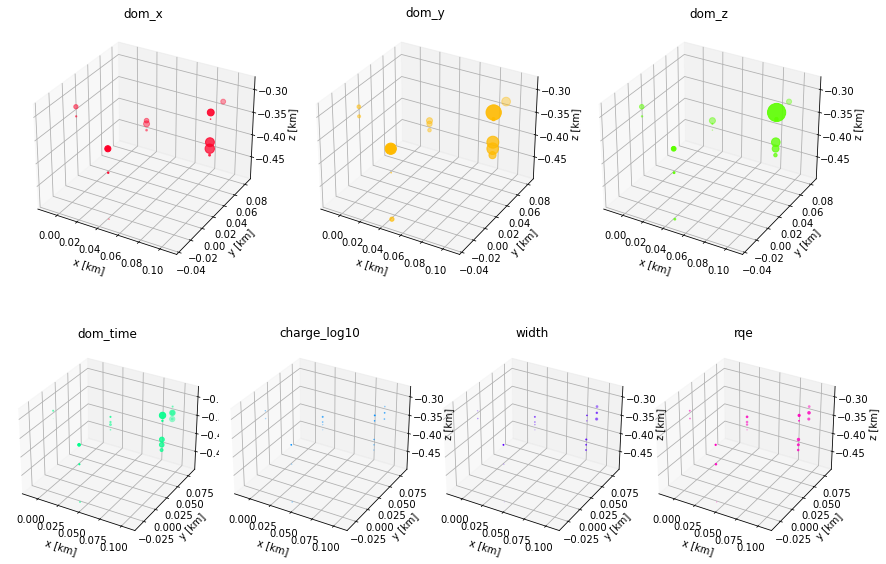

In [12]:
# %matplotlib notebook
%matplotlib inline
k=15
ev, E=event_feats[k], E_grads[k]

axd = plt.figure(figsize=(15,10), constrained_layout=False).subplot_mosaic(
    """
    111122223333
    444555666777
    """
,subplot_kw={"projection": "3d"})
features=["dom_x", "dom_y", "dom_z", "dom_time", "charge_log10", "width", "rqe"]

import matplotlib.cm as mplcm
import matplotlib.colors as colors
cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=6)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)

for i in range(7):
    i_s=str(i+1)
    axd[i_s].scatter(ev[:,0],ev[:,1], ev[:,2], c=scalarMap.to_rgba(i), s=(abs(E[:,i])*100))
    axd[i_s].set(xlabel='x [km]', ylabel='y [km]', zlabel='z [km]', title=features[i])

In [13]:
# [rawE,rawzeni,rawazi,rawzenisig,rawazisig], 
# [gradsE, gradszeni,gradsazi,gradszenisig,gradsazisig], targets, predictions, inputs

In [14]:
# split to all
all_grads=[]
all_feats=[]
for i in tqdm(range(len(raw))):
    _, idx =np.unique(inputs[i][2].numpy(), return_index=True)
#     grad_event=[]
    for j in range(len(raw[0])):
        raw_g1 = np.split(raw[i][j].numpy(),  idx[1:])
        raw_g=np.vstack(raw_g1)
        all_grads.append(raw_g)
#     event_raw_grads1.append(raw_g)
    feat =  np.split(inputs[i][0].numpy(), idx[1:])
    feat=np.vstack(feat)
    all_feats.append(feat)
all_feats=np.vstack(all_feats)
all_grads=np.vstack(all_grads)
# E_grads=np.hstack(E_grads)


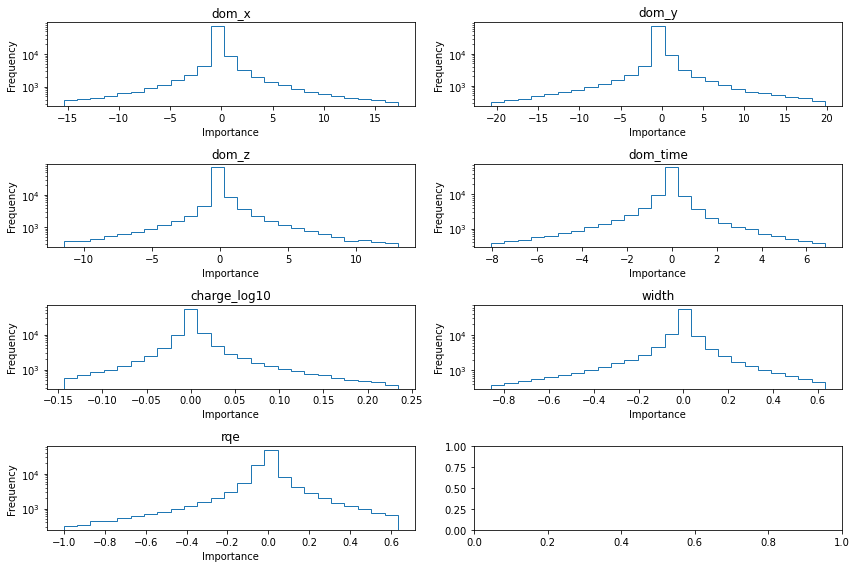

In [15]:
fig,ax=plt.subplots(ncols=2, nrows=4, figsize=(12,8))
ax=ax.flatten()
for i in range(7):
    ax[i].hist(all_grads[:,i], bins=25, histtype='step', range=(np.percentile(all_grads[:,i], 5),np.percentile(all_grads[:,i], 95)))
    ax[i].set(xlabel='Importance', ylabel='Frequency', title=features[i], yscale='log')
    
fig.tight_layout()

In [16]:
# split to all
all_gradsn=[]
for i in tqdm(range(len(raw))):
    _, idx =np.unique(inputs[i][2].numpy(), return_index=True)
#     grad_event=[]
    for j in range(len(raw[0])):
        raw_g1 = np.split(raw[i][j].numpy(),  idx[1:])
        for k in range(len(raw_g1)):
            raw_g1[k]=raw_g1[k]/(np.sum(np.abs(raw_g1[k])))
        raw_g=np.vstack(np.abs(raw_g1))
        all_gradsn.append(raw_g)
all_gradsn=np.vstack(all_gradsn)
# E_grads=np.hstack(E_grads)


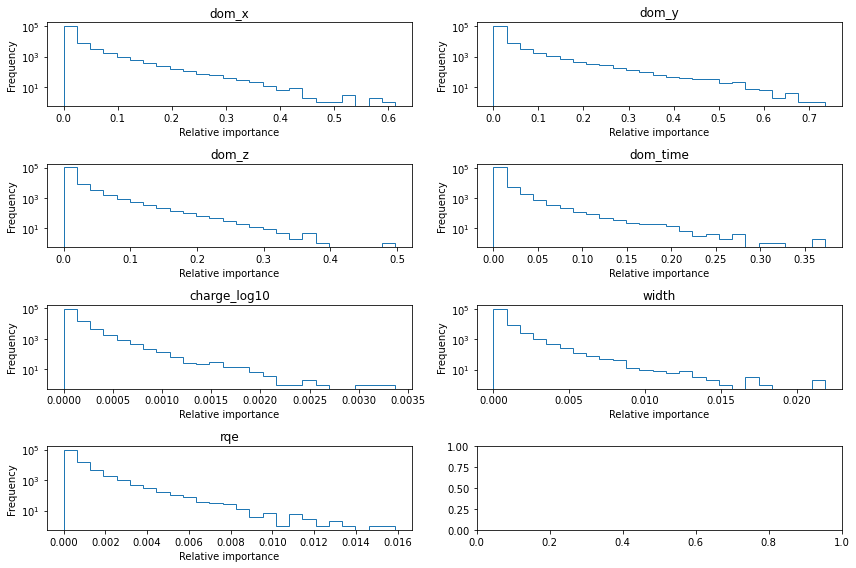

In [17]:
fig,ax=plt.subplots(ncols=2, nrows=4, figsize=(12,8))
ax=ax.flatten()
for i in range(7):
    ax[i].hist(all_gradsn[:,i], bins=25, histtype='step', range=(0,np.max(all_gradsn[:,i])))
    ax[i].set(xlabel='Relative importance', ylabel='Frequency', title=features[i], yscale='log')
    
fig.tight_layout()

In [18]:
import pandas as pd
allfeatdf=pd.DataFrame(all_feats)
allfeatdf.columns=features

In [126]:
# import seaborn as sns
# pl = sns.pairplot(allfeatdf.iloc[:10000], diag_kind='kde', corner=True,
#             x_vars=features[:5], y_vars=features)
# pl.map_lower(sns.kdeplot, levels=4, color=".2")

In [90]:
featg=[feat+'_grad' for feat in features]
dfE=pd.DataFrame(np.vstack(E_grads), columns=featg)
# dfE=dfE[dfE]
for col in dfE.columns:
    dfE=dfE.query(f"{col} != 0")
    dfEfeat=pd.concat([dfE, allfeatdf], axis=1, join='inner')
dfz=pd.DataFrame(np.vstack(z_grads), columns=featg)
for col in dfz.columns:
    dfz=dfz.query(f"{col} != 0")
    dfzfeat=pd.concat([dfz, allfeatdf], axis=1, join='inner')
dfa=pd.DataFrame(np.vstack(a_grads), columns=featg)
for col in dfa.columns:
    dfa=dfa.query(f"{col} != 0")
    dfafeat=pd.concat([dfa, allfeatdf], axis=1, join='inner')
dfzs=pd.DataFrame(np.vstack(zs_grads), columns=featg)
dfas=pd.DataFrame(np.vstack(as_grads), columns=featg)
for col in dfzs.columns:
    dfzs=dfzs.query(f"{col} != 0")
    dfzsfeat=pd.concat([dfzs, allfeatdf], axis=1, join='inner')
dfa=pd.DataFrame(np.vstack(a_grads), columns=featg)
for col in dfas.columns:
    dfas=dfas.query(f"{col} != 0")
    dfasfeat=pd.concat([dfas, allfeatdf], axis=1, join='inner')

In [127]:
# plE = sns.pairplot(dfE, diag_kind='kde', corner=True,
#             x_vars=featg, y_vars=featg)
# # plE.map_lower(sns.kdeplot, levels=4, color=".2")

In [128]:
# plE = sns.pairplot(dfEfeat, diag_kind='kde', corner=True, x_vars=features[:-2]+featg[:-2], y_vars=features[:-2]+featg[:-2])

In [129]:
# plE = sns.pairplot(dfEfeat, diag_kind='kde', corner=True, x_vars=features, y_vars=featg)

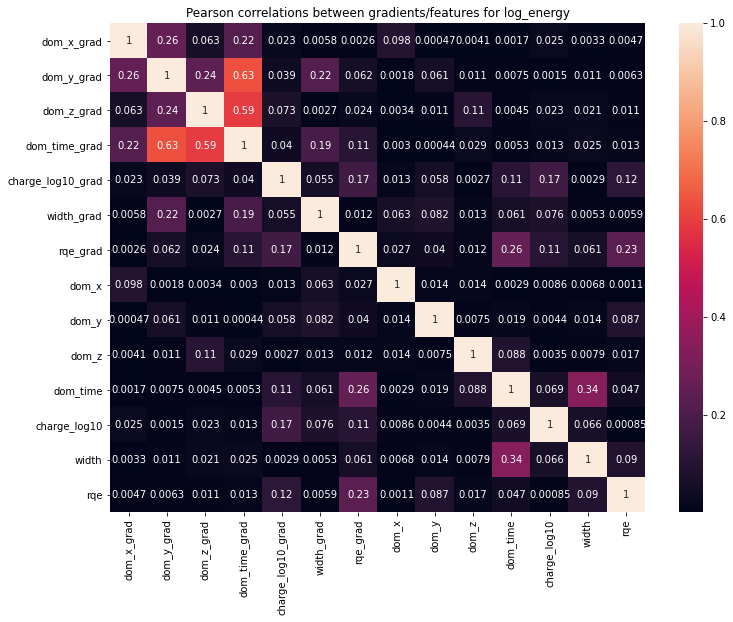

In [125]:
fig, ax=plt.subplots(figsize=(12,9))
ax=sns.heatmap(abs(dfEfeat.corr()), ax=ax, annot=True)
ax.set(title='Pearson correlations between gradients/features for log_energy')
fig.savefig('../../figs_thesis/corr_gradfeat_zekappa.pdf')

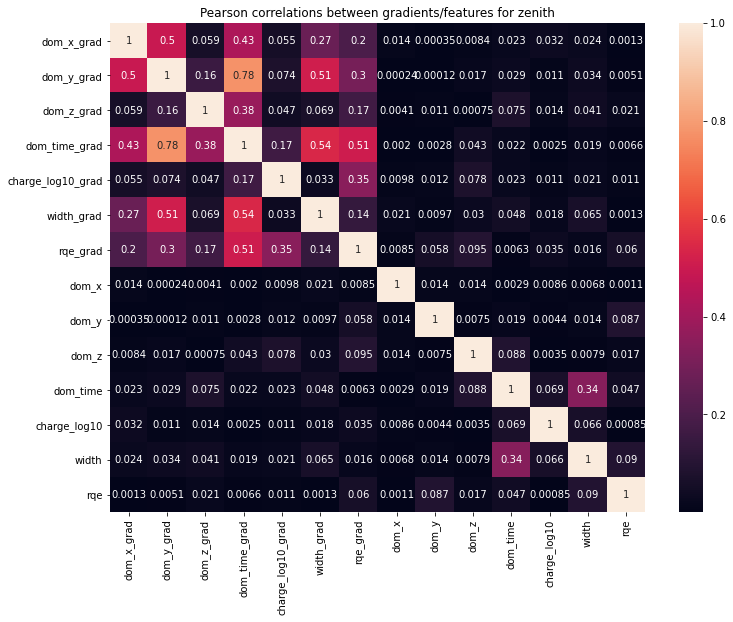

In [123]:
fig, ax=plt.subplots(figsize=(12,9))
ax=sns.heatmap(abs(dfzfeat.corr()), ax=ax, annot=True)
ax.set(title='Pearson correlations between gradients/features for zenith')
fig.savefig('../../figs_thesis/corr_gradfeat_ze.pdf')

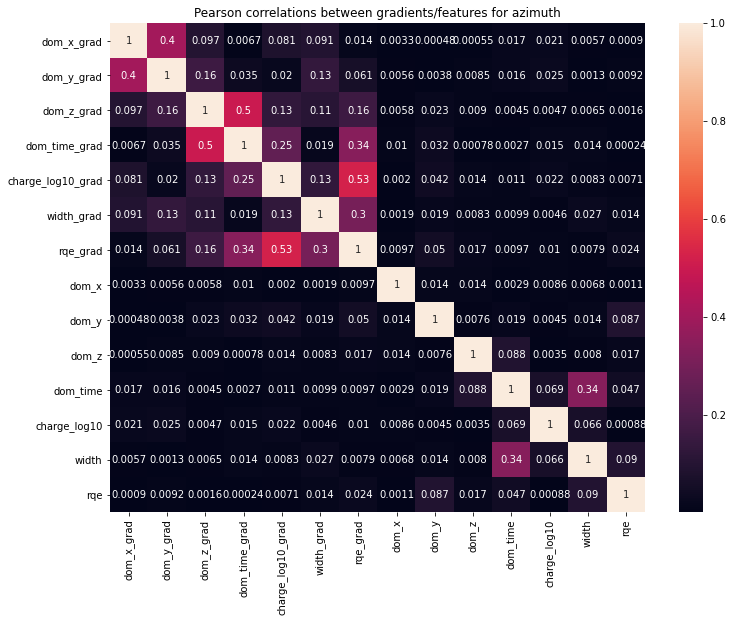

In [124]:
fig, ax=plt.subplots(figsize=(12,9))
ax=sns.heatmap(abs(dfafeat.corr()), ax=ax, annot=True)
ax.set(title='Pearson correlations between gradients/features for azimuth')
fig.savefig('../../figs_thesis/corr_gradfeat_azkappa.pdf')

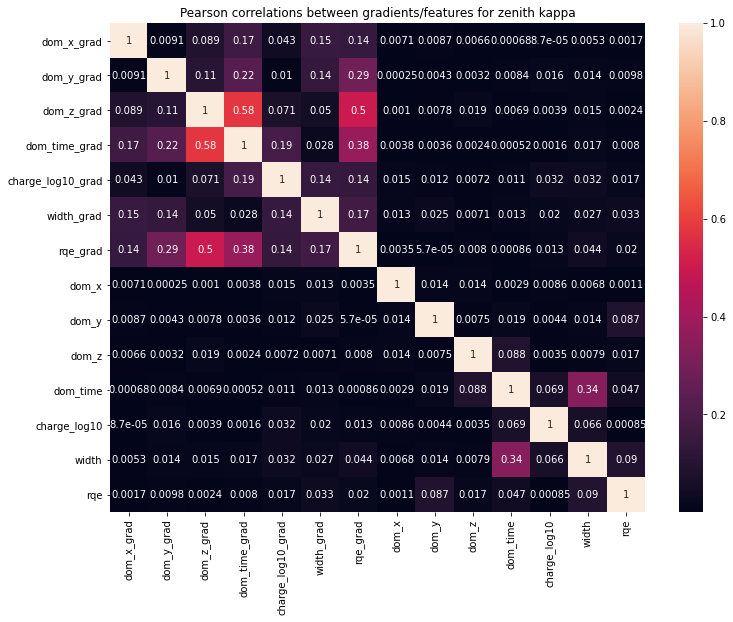

In [122]:
fig, ax=plt.subplots(figsize=(12,9))
ax=sns.heatmap(abs(dfzsfeat.corr()), ax=ax, annot=True)
ax.set(title='Pearson correlations between gradients/features for zenith kappa')
fig.savefig('../../figs_thesis/corr_gradfeat_zekappa.pdf')

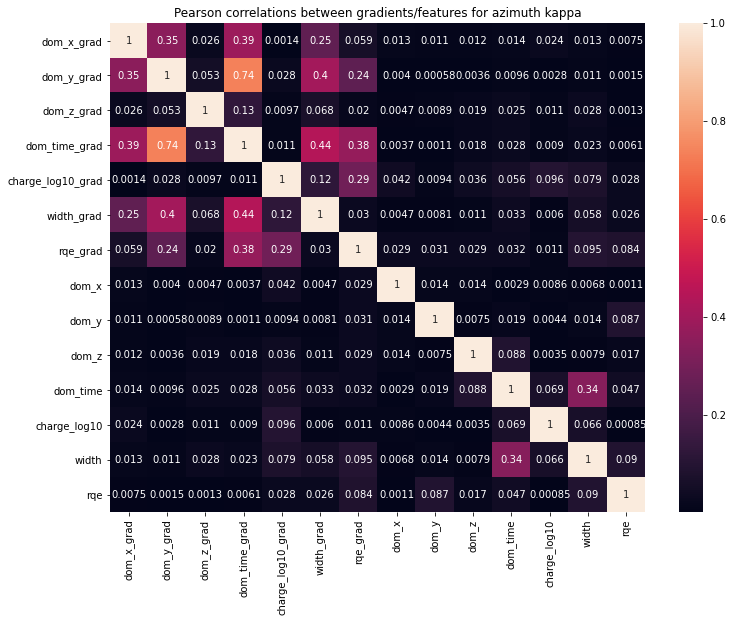

In [121]:
fig, ax=plt.subplots(figsize=(12,9))
ax=sns.heatmap(abs(dfasfeat.corr()), ax=ax, annot=True)
ax.set(title='Pearson correlations between gradients/features for azimuth kappa')
fig.savefig('../../figs_thesis/corr_gradfeat_azkappa.pdf')

In [109]:
mask = np.zeros_like(dfasfeat.corr())
mask[np.triu_indices_from(mask)] = True
mask[:,-7:]=True

In [ ]:
plz = sns.pairplot(dfz, diag_kind='kde', corner=True,
            x_vars=features, y_vars=features)
# plz.map_lower(sns.kdeplot, levels=4, color=".2")

In [ ]:
pla = sns.pairplot(dfa, diag_kind='kde', corner=True,
            x_vars=features, y_vars=features)
# pla.map_lower(sns.kdeplot, levels=4, color=".2")

In [ ]:
plzs = sns.pairplot(dfzs, diag_kind='kde', corner=True,
            x_vars=features, y_vars=features)
# plzs.map_lower(sns.kdeplot, levels=4, color=".2")

In [ ]:
plas = sns.pairplot(dfas, diag_kind='kde', corner=True,
            x_vars=features, y_vars=features)
# plas.map_lower(sns.kdeplot, levels=4, color=".2")

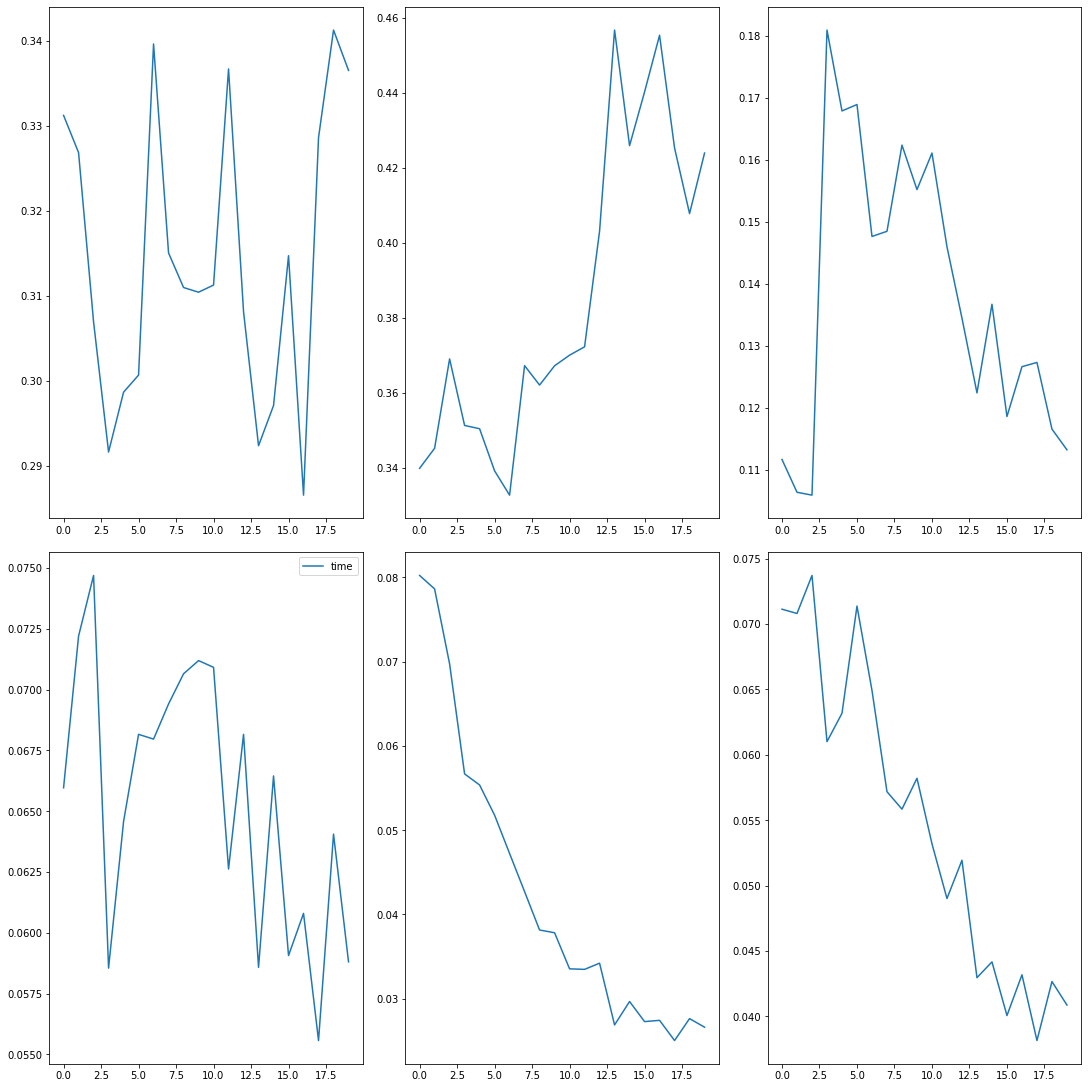

In [31]:
domx=summary[:,0]

ax = plt.figure(constrained_layout=True, figsize=(15,15)).subplot_mosaic(
    [['dom_x', 'dom_y', 'dom_z'],
    ['time', 'charge', 'SRT']])

ax['dom_x'].plot(summary[:,0],label='dom_x')
ax['dom_y'].plot(summary[:,1], label='dom_y')
ax['dom_z'].plot(summary[:,2], label='dom_z')
ax['time'].plot(summary[:,3], label='time')
ax['charge'].plot(summary[:,4], label='charge')
ax['SRT'].plot(summary[:,5], label='SRT')
plt.legend()

In [37]:
grad_dict={'energy':{'dom_x':1,
          'dom_y':1,
          'dom_z':1,
          'time':1,
          'logcharge':1,
          'SRT':1},
           'zenith':{'dom_x':1,
          'dom_y':1,
          'dom_z':1,
          'time':1,
          'logcharge':1,
          'SRT':1},
          'azimuth':{'dom_x':1,
          'dom_y':1,
          'dom_z':1,
          'time':1,
          'logcharge':1,
          'SRT':1},
          'sig_zeni':{'dom_x':1,
          'dom_y':1,
          'dom_z':1,
          'time':1,
          'logcharge':1,
          'SRT':1},
          'sig_azi':{'dom_x':1,
          'dom_y':1,
          'dom_z':1,
          'time':1,
          'logcharge':1,
          'SRT':1}}

In [46]:
feats=list(grad_dict[keys[0]].keys())